# Training

This notebook demonstrates the process of training an ensemble learning model using a provided CSV file. It showcases data preprocessing, model training, evaluation, and saving the trained model. The ensemble method (hard voting, soft voting, or stacking) can be selected based on the user's choice.


## Importing Necessary Libraries

First, we import all the necessary libraries and modules needed for this script. This includes libraries for handling warnings, data manipulation, machine learning, and the custom Ensemble module containing ensemble learning methods.

In [1]:
import pandas as pd
import os
import math
import numpy as np
from src import Utils, Bayes

import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, tokenized_text
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
import joblib

/tmp/ipykernel_18308/2044411934.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Constants

In [2]:
TEST_SIZE = 0.2

SAVE_MODEL = True
MODEL_FOLDER = 'models/model_bayes/test-7' # Where models will be saved
DATASET = 'datasets/datasetall.csv'


## Utility Functions

### Model saving folder creation

Create a folder to save the model based on `MODEL_FOLDER`

In [3]:
if SAVE_MODEL:
  os.makedirs(
    MODEL_FOLDER,
    exist_ok=True, # Create folder if it doesn't exist, else do nothing
  )

  print(f"Saving model at '{MODEL_FOLDER}'")

Saving model at 'models/model_bayes/test-7'


### Function to Read CSV File

The `read_csv_file` function reads the CSV file and returns a pandas DataFrame. If the file is not found, the script will exit with an error message.

In [4]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

dataset = read_csv_file(DATASET)
dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [5]:
dataset['label'].value_counts(ascending=True)

label
0    14115
1    14346
Name: count, dtype: int64

### Function for Train-Test Split

The `get_train_test_split` function splits the dataset into training and testing sets with an 80-20 split ratio and returns them.

In [6]:
random_number_generator = np.random.default_rng(seed=0)
def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 > test_size > 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0] 
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1] 
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )


In [7]:
X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

## Train Data

In [8]:
pd.DataFrame(X_train)

,text
0,Matthew Chang [USERNAME] Remind ko lang di ba ...
1,Yay! The interview served its purpose wellJess...
2,I say DASURV
3,TayNew said Let Leni Lead
4,Gloc 9 is not endorsing Jejomar Binay as his p...
...,...
22764,Nov. 11: on [USERNAME] saw tv ads of Jojo Bina...
22765,Mar Roxas your call for unity describes one th...
22766,Buti nalang nagdecide nakong hindi manood ng T...
22767,sang boto para sa pagbabago. Let Leni Lead phi...


In [9]:
y_train_dataframe = pd.DataFrame(y_train, columns=['label'])
y_train_dataframe

,label
0,1
1,0
2,0
3,0
4,0
...,...
22764,1
22765,1
22766,0
22767,0


In [10]:
y_train_dataframe.value_counts(ascending=True)

label
0        11292
1        11477
Name: count, dtype: int64

## Test Data

In [11]:
pd.DataFrame(X_test)

,text
0,Hindi susuportahan ng theatre and literary est...
1,BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DES...
2,Im proud to be a Filipino and a kakampink like...
3,Grabe noThe hypocrisy of the church to preach ...
4,BBMSARAUniteam Ph Arena BBMSARA
...,...
5687,[USERNAME] Rizalito David is a good man you ca...
5688,A very famous religious cult in the Philippine...
5689,Tama sir VP Leni Di dapat iboto SI BBM Kase No...
5690,RT [USERNAME]: Mar Roxas forever arrogantI can...


In [12]:
y_test_dataframe = pd.DataFrame(y_test, columns=['label'])
y_test_dataframe

,label
0,0
1,1
2,0
3,1
4,0
...,...
5687,0
5688,1
5689,0
5690,1


In [13]:
y_test_dataframe.value_counts(ascending=True)

label
0        2823
1        2869
Name: count, dtype: int64

## CountVectorizer

In [14]:
from os.path import dirname

CountVec = CountVectorizer(
  binary=True,
)

In [15]:
X_train_transformed = CountVec.fit_transform(
  X_train
)

In [16]:
tokenized_text = CountVec.get_tokenized_text()

In [17]:
pd.DataFrame(tokenized_text[:20])

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,matthew,chang,username,remind,ko,lang,di,ba,galit,na,...,again,None,None,None,None,None,None,None,None,None
1,yay,the,interview,served,its,purpose,welljessica,soho,interviews,angat,...,None,None,None,None,None,None,None,None,None,None
2,say,dasurv,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,taynew,said,let,leni,lead,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,gloc,is,not,endorsing,jejomar,binay,as,his,presidential,bet,...,None,None,None,None,None,None,None,None,None,None
5,proud,to,say,na,kakampink,po,ang,nanay,ko,uban,...,None,None,None,None,None,None,None,None,None,None
6,chewie,my,kakampink,fur,baby,showing,off,his,leni,shirt,...,last,post,hbdpresident,leni,ipanalona10toparasalahat,leni,kiko,None,None,None
7,rt,username,sino,nognog,only,binay,sino,pandak,only,binay,...,None,None,None,None,None,None,None,None,None,None
8,this,event,unity,walkwas,organized,by,comelec,and,other,government,...,halalan,None,None,None,None,None,None,None,None,None
9,diba,binay,vice,ka,ni,pnoy,edi,wala,ka,din,...,None,None,None,None,None,None,None,None,None,None


In [18]:
pd.DataFrame([CountVec.vocabulary_]).T.head(30)

,0
matthew,21543
chang,5740
username,37801
remind,31198
ko,17072
lang,17830
di,7901
ba,2728
galit,11007
na,22826


In [19]:
pd.DataFrame(X_train_transformed.toarray())

,0,1,2,3,4,5,6,7,8,9,...,39653,39654,39655,39656,39657,39658,39659,39660,39661,39662
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print(X_train_transformed[:20])

  (0, 21543)	1
  (0, 5740)	1
  (0, 37801)	1
  (0, 31198)	1
  (0, 17072)	1
  (0, 17830)	1
  (0, 7901)	1
  (0, 2728)	1
  (0, 11007)	1
  (0, 22826)	1
  (0, 15550)	1
  (0, 8742)	1
  (0, 32107)	1
  (0, 35496)	1
  (0, 21302)	1
  (0, 19378)	1
  (0, 25135)	1
  (0, 37825)	1
  (0, 35527)	1
  (0, 16597)	1
  (0, 21092)	1
  (0, 12914)	1
  (0, 13471)	1
  (0, 22312)	1
  (0, 26607)	1
  :	:
  (18, 2675)	1
  (18, 35293)	1
  (18, 37364)	1
  (18, 20340)	1
  (18, 5065)	1
  (18, 1803)	1
  (18, 27735)	1
  (18, 21678)	1
  (18, 11631)	1
  (19, 22826)	1
  (19, 35922)	1
  (19, 153)	1
  (19, 22793)	1
  (19, 36056)	1
  (19, 12281)	1
  (19, 31832)	1
  (19, 7394)	1
  (19, 26167)	1
  (19, 30885)	1
  (19, 37646)	1
  (19, 9220)	1
  (19, 31433)	1
  (19, 7990)	1
  (19, 9222)	1
  (19, 1310)	1


## Bernoulli Naive Bayes

In [21]:
bayes = BernoulliNB()
bayes

BernoulliNB()

In [22]:
bayes.fit(X_train_transformed, y_train)

BernoulliNB()

## Results

In [31]:
X_test_transformed = CountVec.transform(X_test)

In [32]:
print(X_test_transformed)

  (0, 1712)	1
  (0, 1768)	1
  (0, 2423)	1
  (0, 5673)	1
  (0, 6104)	1
  (0, 7202)	1
  (0, 7452)	1
  (0, 8293)	1
  (0, 10143)	1
  (0, 10783)	1
  (0, 11900)	1
  (0, 12914)	1
  (0, 13340)	1
  (0, 14941)	1
  (0, 15550)	1
  (0, 18140)	1
  (0, 18333)	1
  (0, 19314)	1
  (0, 19584)	1
  (0, 21468)	1
  (0, 21967)	1
  (0, 22021)	1
  (0, 22826)	1
  (0, 25135)	1
  (0, 28402)	1
  :	:
  (5689, 33642)	1
  (5689, 35349)	1
  (5689, 38304)	1
  (5690, 2299)	1
  (5690, 5328)	1
  (5690, 10427)	1
  (5690, 10605)	1
  (5690, 12856)	1
  (5690, 12986)	1
  (5690, 13815)	1
  (5690, 14711)	1
  (5690, 17601)	1
  (5690, 21044)	1
  (5690, 26167)	1
  (5690, 29236)	1
  (5690, 29841)	1
  (5690, 31832)	1
  (5690, 32031)	1
  (5690, 33318)	1
  (5690, 35922)	1
  (5690, 37801)	1
  (5691, 15947)	1
  (5691, 18050)	1
  (5691, 18185)	1
  (5691, 18367)	1


In [33]:
y_preds = bayes.predict(X_test_transformed)

In [34]:
accuracy = accuracy_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

if SAVE_MODEL:
  pd.DataFrame([{
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1': f1,
  }]).to_csv(f'{MODEL_FOLDER}/bayes_results.csv', index=False)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.8185172171468728
Precision: 0.7899557801642451
Recall: 0.8717323109097247
F1: 0.8288318144159071


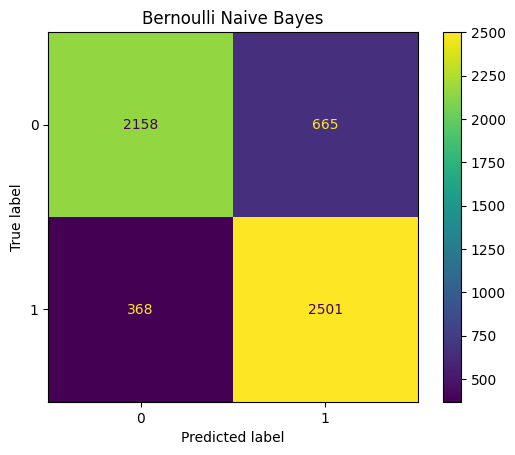

In [35]:
conf_matrix = confusion_matrix(y_test, y_preds)

conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)

if SAVE_MODEL:
  conf_matrix_display.plot()
  conf_matrix_display.figure_.savefig(f'{MODEL_FOLDER}/conf_matrix.png')

plt.title("Bernoulli Naive Bayes")
plt.show()

In [36]:
if SAVE_MODEL:
  joblib.dump(CountVec, f'{MODEL_FOLDER}/countvec.pkl', compress=True)
  joblib.dump(bayes, f'{MODEL_FOLDER}/bayes.pkl', compress=True)
  print(f"Saved model to {MODEL_FOLDER}/bayes.pkl")

Saved model to models/model_bayes/test-7/bayes.pkl


## Manual Testing

In [38]:
manual_transformed = CountVec.transform([
  "Hello world!"
])

In [73]:
bayes.predict_proba(manual_transformed)
bayes._joint_log_likelihood(manual_transformed)

array([[0.59278539, 0.40721461]])

In [40]:
print(manual_transformed)

  (0, 12680)	1
  (0, 39088)	1


In [44]:
np.exp(bayes.class_log_prior_)

array([0.49593746, 0.50406254])

In [47]:
bayes.feature_log_prob_.shape

(2, 39663)

In [86]:
negative_prob = np.log(1 - np.exp(bayes.feature_log_prob_))
negative_prob

array([[-6.19990277e-04, -4.42810971e-04, -1.77100859e-04, ...,
        -1.77100859e-04, -8.85465091e-05, -8.85465091e-05],
       [-8.71193972e-05, -1.74246385e-04, -8.71193972e-05, ...,
        -8.71193972e-05, -3.48523137e-04, -1.74246385e-04]])

In [53]:
features = bayes.feature_log_prob_

In [79]:
output = features - negative_prob
output

array([[-7.38549675, -7.72214617, -8.63870261, ..., -8.63870261,
        -9.33193834, -9.33193834],
       [-9.34818744, -8.65495313, -9.34818744, ..., -9.34818744,
        -7.96163167, -8.65495313]])

In [80]:
output = output[:, 12860] + output[:, 39088]
output

array([-14.99694445, -14.26189251])

In [84]:
negative_prob.sum(axis=1)

array([-20.49077158, -20.21086902])

In [81]:
output += bayes.class_log_prior_ + negative_prob.sum(axis=1)

In [77]:
log_proba = output

In [85]:
log_proba

array([-36.19611685, -35.16549608])

In [70]:
# Calculate denominator
max_output = log_proba.max()
logsumexp_result = max_output + np.log(np.sum(np.exp(log_proba - max_output)))
logsumexp_result

-34.85285182883163

In [71]:
np.exp(log_proba - logsumexp_result)

array([0.26285055, 0.73714945])